This file is to analyze the results and save them


### import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from torch.distributions.multivariate_normal import MultivariateNormal

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 13,
    "ytick.labelsize": 13
})

#### My own pkgs

In [3]:
import importlib

from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, geodesic_dist
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from utils.brain_plot import U2BrainVec, reorderU 
from utils.reparam import theta_raw_2out, normcdf_np, normcdf_torch, logistic_np, logistic_torch
from utils.stable import paras_table_check
from sgm.sgm import SGM
from spectrome import Brain, path, functions
from features.psm import obt_psm_fs, obt_psm_raw
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT
from models.embedding_nets import SummaryNet
from sgm.data_gen import simulator_data

In [4]:
import utils.misc
importlib.reload(utils.misc)

<module 'utils.misc' from '/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/utils/misc.py'>

In [5]:
#torch.set_default_tensor_type(torch.DoubleTensor)

### Load real data PSD and brain

#### PSD and connectome

In [6]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

#### Set up Parameters

In [7]:
# some constant parameters for this file
paras = edict()
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (5, 20), (0.001,0.7), (0.001,2.0), (5.0,30.0))
#Bounds for taue, taui, alpha, speed, gei, gii, tauC
# (0.001,0.7), (0.001,2.0) when considering stable checking.
# (0.001,0.5), (0.001,1.5) as safe (narrower) bounds

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.num_prior_sps = int(1e5)
paras.den_est = "nsf"
paras.is_embed = False
paras.noise_sd = 1.6

paras.prior_sd = 10

In [8]:
# paras  for this file
_paras = edict()
_paras.num_prior_spss = np.array([800, 1600, 3125, 6250, 12500, 25000, 50000, 100000, 200000])
_paras.filss = []
for num_prior_sps in _paras.num_prior_spss:
    _folder_path = f"./new_bds[0-9]*_reparam{num_prior_sps:.0f}" +\
                   f"_sd{paras.noise_sd*100:.0f}" +\
                   f"_denest{paras.den_est}" +\
                   f"_embed{paras.is_embed}"
    fils = list(RES_ROOT.glob(_folder_path))
    fils = sorted(fils, key=lambda x: int(x.stem.split("bds")[1].split("_")[0]))
    _paras.filss.append(fils)

In [9]:
_paras.plot_sets = edict()
_paras.plot_sets.col = ["dodgerblue", "coral"]
_paras.plot_sets.alpha = 0.8
_paras.plot_sets.marker = ["o", "h"]

In [10]:
prior = MultivariateNormal(loc=torch.zeros(7), covariance_matrix=torch.eye(7)*(paras.prior_sd**2))

In [11]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

In [12]:
meg_psd_curve = np.median([np.mean(psd_2tr(ind_psd[:, :, ix]), axis=0) for ix in range(36)], axis=0)
#meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])

# the estimated spatial feature from MEG
meg_sps = []
meg_sp_raws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS)
    meg_sps.append(curMEGSP)
    meg_sp_raws.append(curMEGSPRaw.sum(axis=1))

meg_sps = np.array(meg_sps)
meg_sp_raws = np.array(meg_sp_raws)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 40.00it/s]


#### Some fns

In [13]:
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

In [14]:
def _filter_unstable(theta_raw, prior_bds, x=None):
    """This fn is to remove unstable SGM parameters
        args: theta_raw: parameters: num of sps x dim
                order: ['Taue', 'Taui', 'TauC', 'Speed', 'alpha', 'gii', 'gei']
    """
    theta = _theta_raw_2out(theta_raw.numpy(), prior_bds)
    stable_idxs = paras_table_check(theta)
    
    # keep stable sps only
    theta_raw_stable = theta_raw[stable_idxs==0]
    if x is not None:
        x_stable = x[stable_idxs==0]
        return theta_raw_stable, x_stable
    else:
        return theta_raw_stable

### Analysis

In [15]:
all_ress = []
for fils in tqdm(_paras.filss):
    all_res = []
    for cur_fil in fils:
        cur_res = load_pkl_folder2dict(cur_fil, ["raw_sp", "*_raw", "posterior"], verbose=False)
        all_res.append(cur_res)
    all_ress.append(all_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:12<00:00, 28.10s/it]


In [16]:
results_across_num = []

#for fils in tqdm(_paras.filss):
for all_res in tqdm(all_ress):
    result = ddict(list)
    #for cur_fil in fils:
        #cur_res = load_pkl_folder2dict(cur_fil, ["raw_sp", "*_raw", "posterior"], verbose=False)
    for cur_res in all_res:
        est_psds = []
        est_FCs = []
        for post_psd in cur_res.fb_post_res:
            est_psd = np.mean(post_psd[:, :-68], axis=0)
            est_psd = est_psd.reshape(68, 40)
            est_psds.append(est_psd)
            est_FCs.append(np.corrcoef(est_psd))
            
        # single corr
        #sgm_psd_curve_fb = np.array(est_psds).mean(axis=1).mean(axis=0)
        sgm_psd_curve_fb = np.median(np.mean(np.array(est_psds), axis=1), axis=0)
        corr = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve_fb))[0]
        #print(f"Corr is {corr:.3f}")
        
        # Corrs for PSD and spatial features for each subject
        sgm_psd_roi_sub_fb = np.array(est_psds)
        corrs_roi_sub_fb = []
        for ix in range(meg_psd_roi_sub.shape[0]):
            cur_meg = meg_psd_roi_sub[ix]
            cur_sgm = sgm_psd_roi_sub_fb[ix]
            corrs_roi_sub_fb.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
        corrs_roi_sub_fb = np.array(corrs_roi_sub_fb)
        
        # geodesic dist
        geo_dists = [geodesic_dist(np.corrcoef(meg_psd_roi_sub[iz]), est_FCs[iz]) for iz in range(36)]
        
        #print(np.median(corrs_roi_sub_fb), np.mean(corrs_roi_sub_fb))
        result["sgm_psd_curs"].append(sgm_psd_curve_fb)
        result["corr"].append(corr)
        result["corrs_roi_sub"].append(corrs_roi_sub_fb)
        result["geo_dists"].append(geo_dists)
    results_across_num.append(edict(result))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.03s/it]


100000


array([0.9743696 , 0.97474431, 0.97619804, 0.9787275 , 0.98120792,
       0.98410734, 0.98762606, 0.98922568, 0.98915448])

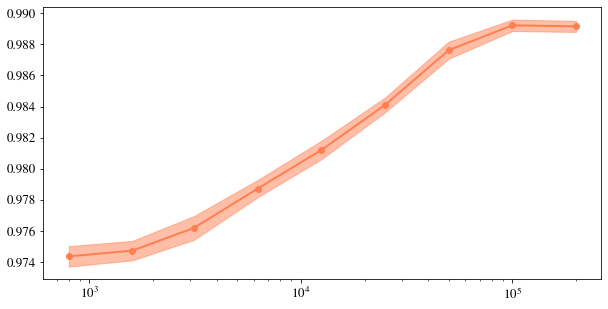

In [18]:
idxs = np.arange(len(results_across_num))
ys = np.array([np.mean(result.corr) for result in results_across_num])
ys_se = np.array([np.std(result.corr) for result in results_across_num])/np.sqrt(10)
lows = ys - 1.96*ys_se
ups = ys + 1.96*ys_se
plt.figure(figsize=[10, 5])
plt.plot(_paras.num_prior_spss[idxs], ys[idxs], "o-", lw=2,
         color=_paras.plot_sets.col[1])
plt.fill_between(_paras.num_prior_spss[idxs], lows[idxs] ,ups[idxs], alpha=0.5,
                 color=_paras.plot_sets.col[1])
plt.xscale("log")
print(np.array(_paras.num_prior_spss[idxs])[np.argmax(ys[idxs])])
ys

100000


array([0.88658251, 0.8883814 , 0.89062042, 0.89444629, 0.89668506,
       0.89859352, 0.90530234, 0.90571913, 0.90549064])

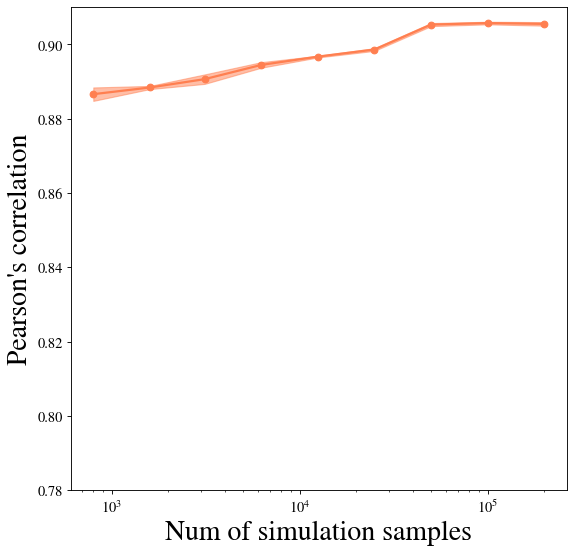

In [24]:
idxs = np.arange(len(results_across_num))
ys = np.array([np.median(result.corrs_roi_sub, axis=1).mean() for result in results_across_num])
ys_se = np.array([np.std(np.median(result.corrs_roi_sub, axis=1))
                  for result in results_across_num])/np.sqrt(10)
lows = ys - 1.96*ys_se
ups = ys + 1.96*ys_se
plt.figure(figsize=[8, 8], dpi=80)
plt.plot(_paras.num_prior_spss[idxs], ys[idxs], "o-", lw=2, 
         color=_paras.plot_sets.col[1])
plt.fill_between(_paras.num_prior_spss[idxs], lows[idxs], ups[idxs], alpha=0.5,
                 color=_paras.plot_sets.col[1])
plt.xscale("log")
plt.xlabel("Num of simulation samples", fontsize=25)
_ = plt.ylabel("Pearson's correlation", fontsize=25)
plt.ylim([0.78, 0.91])
plt.savefig(FIG_ROOT/"newbds_tuningSps_roi_PSDcorr.jpg", dpi=1000)
print(np.array(_paras.num_prior_spss[idxs])[np.argmax(ys)])
ys

array([161.03632637, 160.80334677, 161.23694639, 160.78719489,
       161.22993118, 161.16241073, 161.70295546, 162.31836363,
       162.48176673])

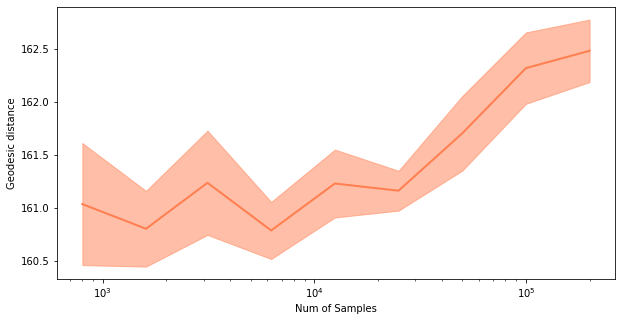

In [20]:
idxs = np.arange(len(results_across_num))
ys = np.array([np.median(result.geo_dists, axis=1).mean() for result in results_across_num])
ys_se = np.array([np.std(np.mean(result.geo_dists, axis=1))
                  for result in results_across_num])/np.sqrt(10)
lows = ys - 1.96*ys_se
ups = ys + 1.96*ys_se
plt.figure(figsize=[10, 5])
plt.plot(_paras.num_prior_spss[idxs], ys[idxs], lw=2, 
         color=_paras.plot_sets.col[1])
plt.fill_between(_paras.num_prior_spss[idxs], lows[idxs], ups[idxs], alpha=0.5,
                 color=_paras.plot_sets.col[1])
plt.xscale("log")
plt.ylabel("Geodesic distance")
plt.xlabel("Num of Samples")
ys

### PSD Cur plot

In [39]:
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
all_markers = ["x", "o", 'D']
all_cols = cm.rainbow(np.linspace(0, 1, 3))
#all_markers = list(Line2D.markers.keys())[3:]
#all_cols = cm.rainbow(np.linspace(0, 1, len(_paras.num_prior_spss)))

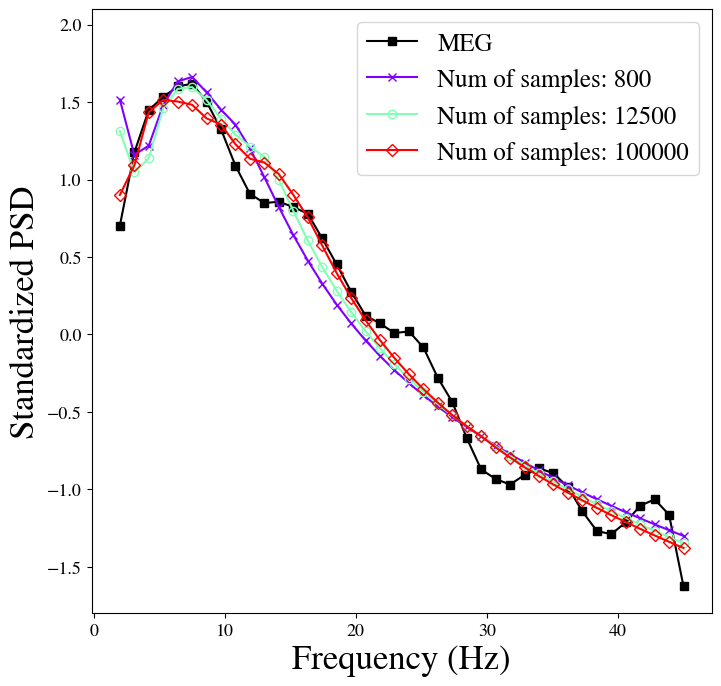

In [40]:
plt.figure(figsize=[8, 8], dpi=100)
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',marker = 's',
         color = 'k', label = "MEG")
flag = 0
for ix, cur_num in enumerate(_paras.num_prior_spss[:]):
    if cur_num not in [800, 12500, 100000]:
        continue
    label=f"Num of samples: {cur_num}"
    plt.plot(FREQS, 
             stdz_vec(np.mean(results_across_num[ix].sgm_psd_curs, axis=0)),
             linestyle = '-',marker=all_markers[flag] ,
             fillstyle = 'none',color=all_cols[flag], label=label)
    plt.xlabel('Frequency (Hz)', fontsize = 25)
    plt.ylabel('Standardized PSD', fontsize = 25)
    flag += 1
plt.ylim([-1.8, 2.1])
plt.legend(fontsize=18)
plt.savefig(FIG_ROOT/"newbds_tuningNumSps_overall_PSDs.jpg", dpi=1000)